In [1]:
import numpy as np
from polartoolkit import fetch, maps, utils, regions, profiles
import verde as vd
import numpy as np
import os
os.environ["POLARTOOLKIT_HEMISPHERE"] = "south"

In [2]:
region = regions.getz_ice_shelf

# Use source ID from Bedmachine to identify coordinates of known bed topography
# get bedmachine data id grid
number_to_source = {
    0: "no_data",
    1: "rema",
    2: "radar",
    7: "seismic",
    10: "multibeam",
}
dataid = fetch.bedmachine(layer="dataid").compute()

# drop grid cells of "no_data"
dataid_ds = dataid.where(dataid != 0, drop=True)

# turn into dataframe
dataid_df = (
    vd.grid_to_table(dataid_ds)
    .dropna()
    .rename(columns={"x": "easting", "y": "northing"})
)
dataid_df["source"] = dataid_df.dataid.map(number_to_source)
dataid_df = dataid_df[["easting", "northing", "dataid", "source"]]

# only keep points in ice shelf region
onshore_points= utils.points_inside_region(dataid_df, region)
onshore_points

easting  northing  dataid     source
60450626 -1624000   -664000    10.0  multibeam
60450627 -1623500   -664000    10.0  multibeam
60450628 -1623000   -664000    10.0  multibeam
60450629 -1622500   -664000    10.0  multibeam
60450630 -1622000   -664000    10.0  multibeam
...           ...       ...     ...        ...
71990075 -1139500  -1214500     1.0       rema
72000554 -1140000  -1215000     1.0       rema
72000555 -1139500  -1215000     1.0       rema
72011033 -1140500  -1215500     1.0       rema
72011034 -1140000  -1215500     1.0       rema

[65343 rows x 4 columns]

requested spacing (500.0) is smaller than the original (1000.0).


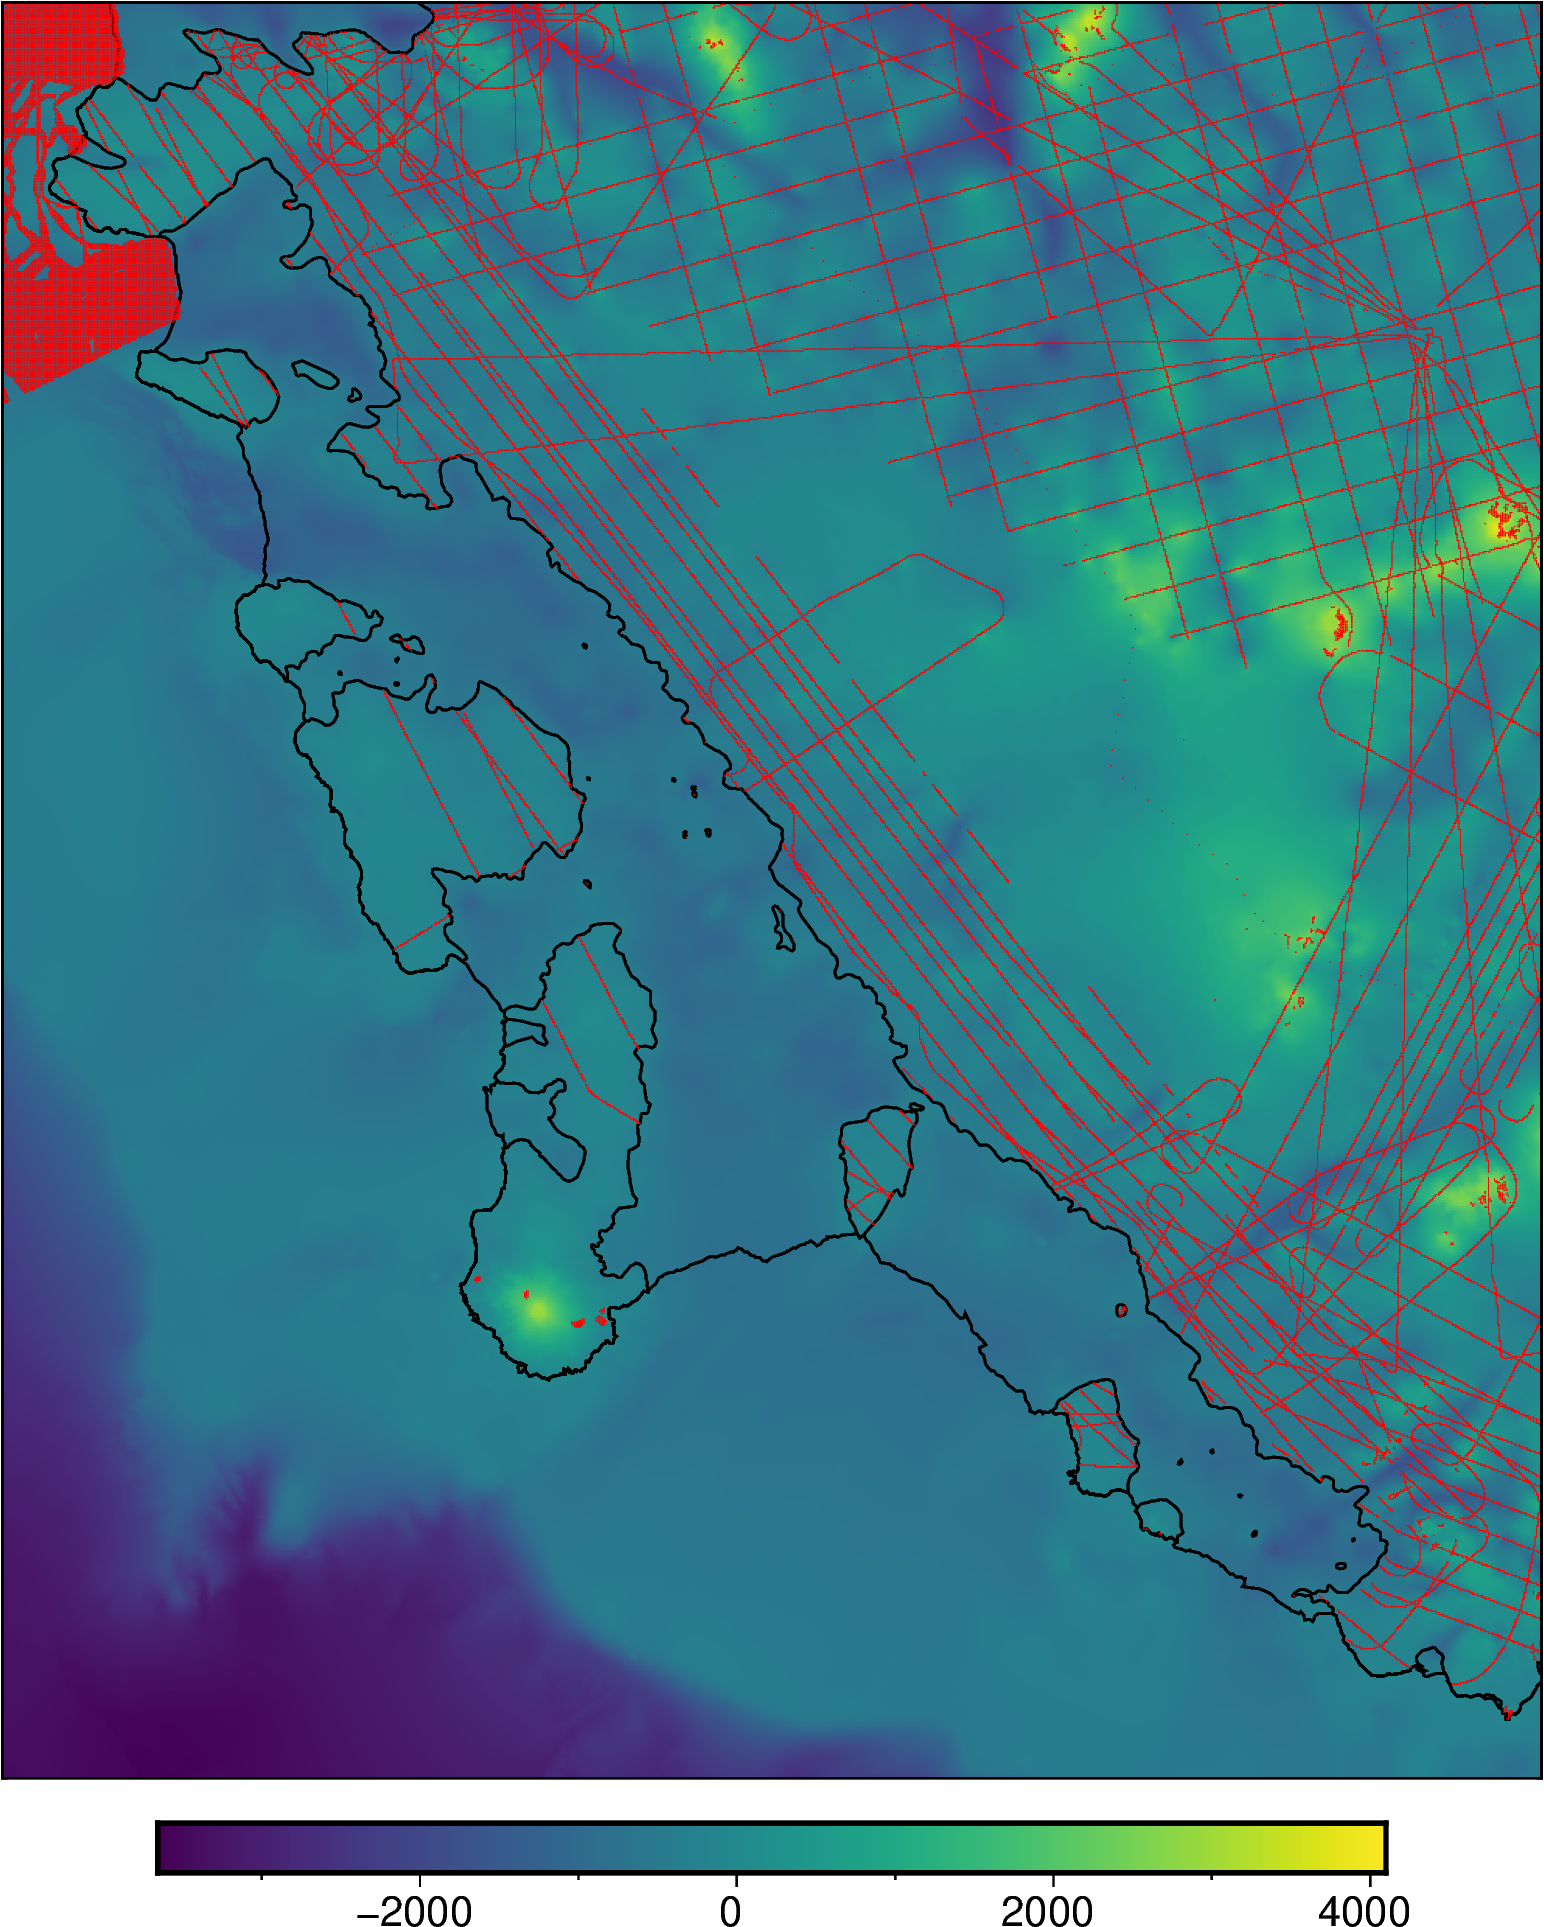

In [3]:
# get bedmap3 bed topography grid
bed_topography = fetch.bedmap3(layer="bed", region = region, reference="ellipsoid")

# show map of the points
fig = maps.plot_grd(bed_topography, coast=True)
fig.add_points(onshore_points, style="p.2p", fill="red")
fig.show()

# Get offshore points of known bathymetry

In [4]:
import pandas as pd
import geopandas as gpd
import shapely

def polygons_to_points(
    polygons: gpd.GeoDataFrame,
    spacing: float = 100,
) -> pd.DataFrame:
    """
    Convert a geodataframe of polygons to a grid of points with a specified spacing.

    Parameters
    ----------
    polygons : geopandas.GeoDataFrame
        Geodataframe of polygons to convert to points
    spacing : float, optional
        Spacing between points, by default 100

    Returns
    -------
    pd.DataFrame
        Dataframe of points with columns "easting", "northing", and "geometry"
    """
    points_list = []
    for _, row in polygons.iterrows():
        points_list.append(polygon_to_points(row, spacing=spacing))

    return pd.concat(points_list)


def polygon_to_points(
    polygon: gpd.GeoSeries,
    spacing: float = 100,
) -> pd.DataFrame:
    """
    Convert a polygon shapefile to a grid of points with a specified spacing. Also
    include the vertices of the polygon.

    Parameters
    ----------
    polygon : gpd.GeoSeries
        Polygon shapefile to convert to points
    spacing : float, optional
        Spacing between points, by default 100

    Returns
    -------
    pd.DataFrame
        Dataframe of points with columns "easting", "northing", and "geometry"
    """

    # get bounds of polygon
    bounds = polygon.geometry.bounds

    # create grid of points
    x_coords = np.arange(bounds[0], bounds[2], spacing)
    y_coords = np.arange(bounds[1], bounds[3], spacing)
    points = [shapely.geometry.Point(x, y) for x in x_coords for y in y_coords]

    # Filter points within the polygon
    points_in_polygon = [point for point in points if polygon.geometry.contains(point)]

    # add vertices of polygon
    points_in_polygon.extend(
        [shapely.geometry.Point(x, y) for (x, y) in polygon.geometry.exterior.coords]
    )

    # add points along edges
    points_in_polygon.extend(
        [
            shapely.geometry.Point(x, y)
            for (x, y) in polygon.geometry.segmentize(spacing).exterior.coords
        ]
    )

    # convert to geodataframe
    points_gdf = gpd.GeoDataFrame(geometry=points_in_polygon)

    # add easting and northing columns
    points_gdf["easting"] = [p.x for p in points_gdf.geometry]
    points_gdf["northing"] = [p.y for p in points_gdf.geometry]

    return points_gdf

In [5]:
# fetch IBCSO points for region
ibcso_points_gdf, ibcso_polygons_gdf = fetch.ibcso_coverage(region=region)

# drop points with TID of 45, meaning it's from gravity inversion
ibcso_points_gdf = ibcso_points_gdf[ibcso_points_gdf.dataset_tid != 45]

# convert polygons (mostly swath multibeam) to grid of points which are within the
# polygon with a grid spacing specified
polygon_points = None
if len(ibcso_polygons_gdf) > 0:
    try:
        polygon_points = polygons_to_points(
            ibcso_polygons_gdf,
            spacing=1e3,
        )
    except ValueError as e:
        print(e)
        print("Failed to convert polygons to points")

# combine IBCSO points and polygon points
offshore_points= pd.concat([ibcso_points_gdf, polygon_points])

# drop some columns
offshore_points= offshore_points.drop(columns=["geometry", "weight", "dataset_tid"])

offshore_points

C:\Users\iii\anaconda3\envs\Semesterproject_test\Lib\site-packages\geopandas\array.py:1754: UserWarning: CRS not set for some of the concatenation inputs. Setting output's CRS as WGS 84 / Antarctic Polar Stereographic (the single non-null crs provided).
  return GeometryArray(data, crs=_get_common_crs(to_concat))


dataset_name       easting      northing
15   NBP99_9.xyz -1.419333e+06 -1.188782e+06
15   NBP99_9.xyz -1.448801e+06 -1.233985e+06
15   NBP99_9.xyz -1.448857e+06 -1.233818e+06
15   NBP99_9.xyz -1.448893e+06 -1.233642e+06
15   NBP99_9.xyz -1.448882e+06 -1.233529e+06
..           ...           ...           ...
427          NaN -1.622914e+06 -9.779268e+05
428          NaN -1.623261e+06 -9.787745e+05
429          NaN -1.623609e+06 -9.796223e+05
430          NaN -1.623957e+06 -9.804700e+05
431          NaN -1.624000e+06 -9.804825e+05

[88780 rows x 3 columns]

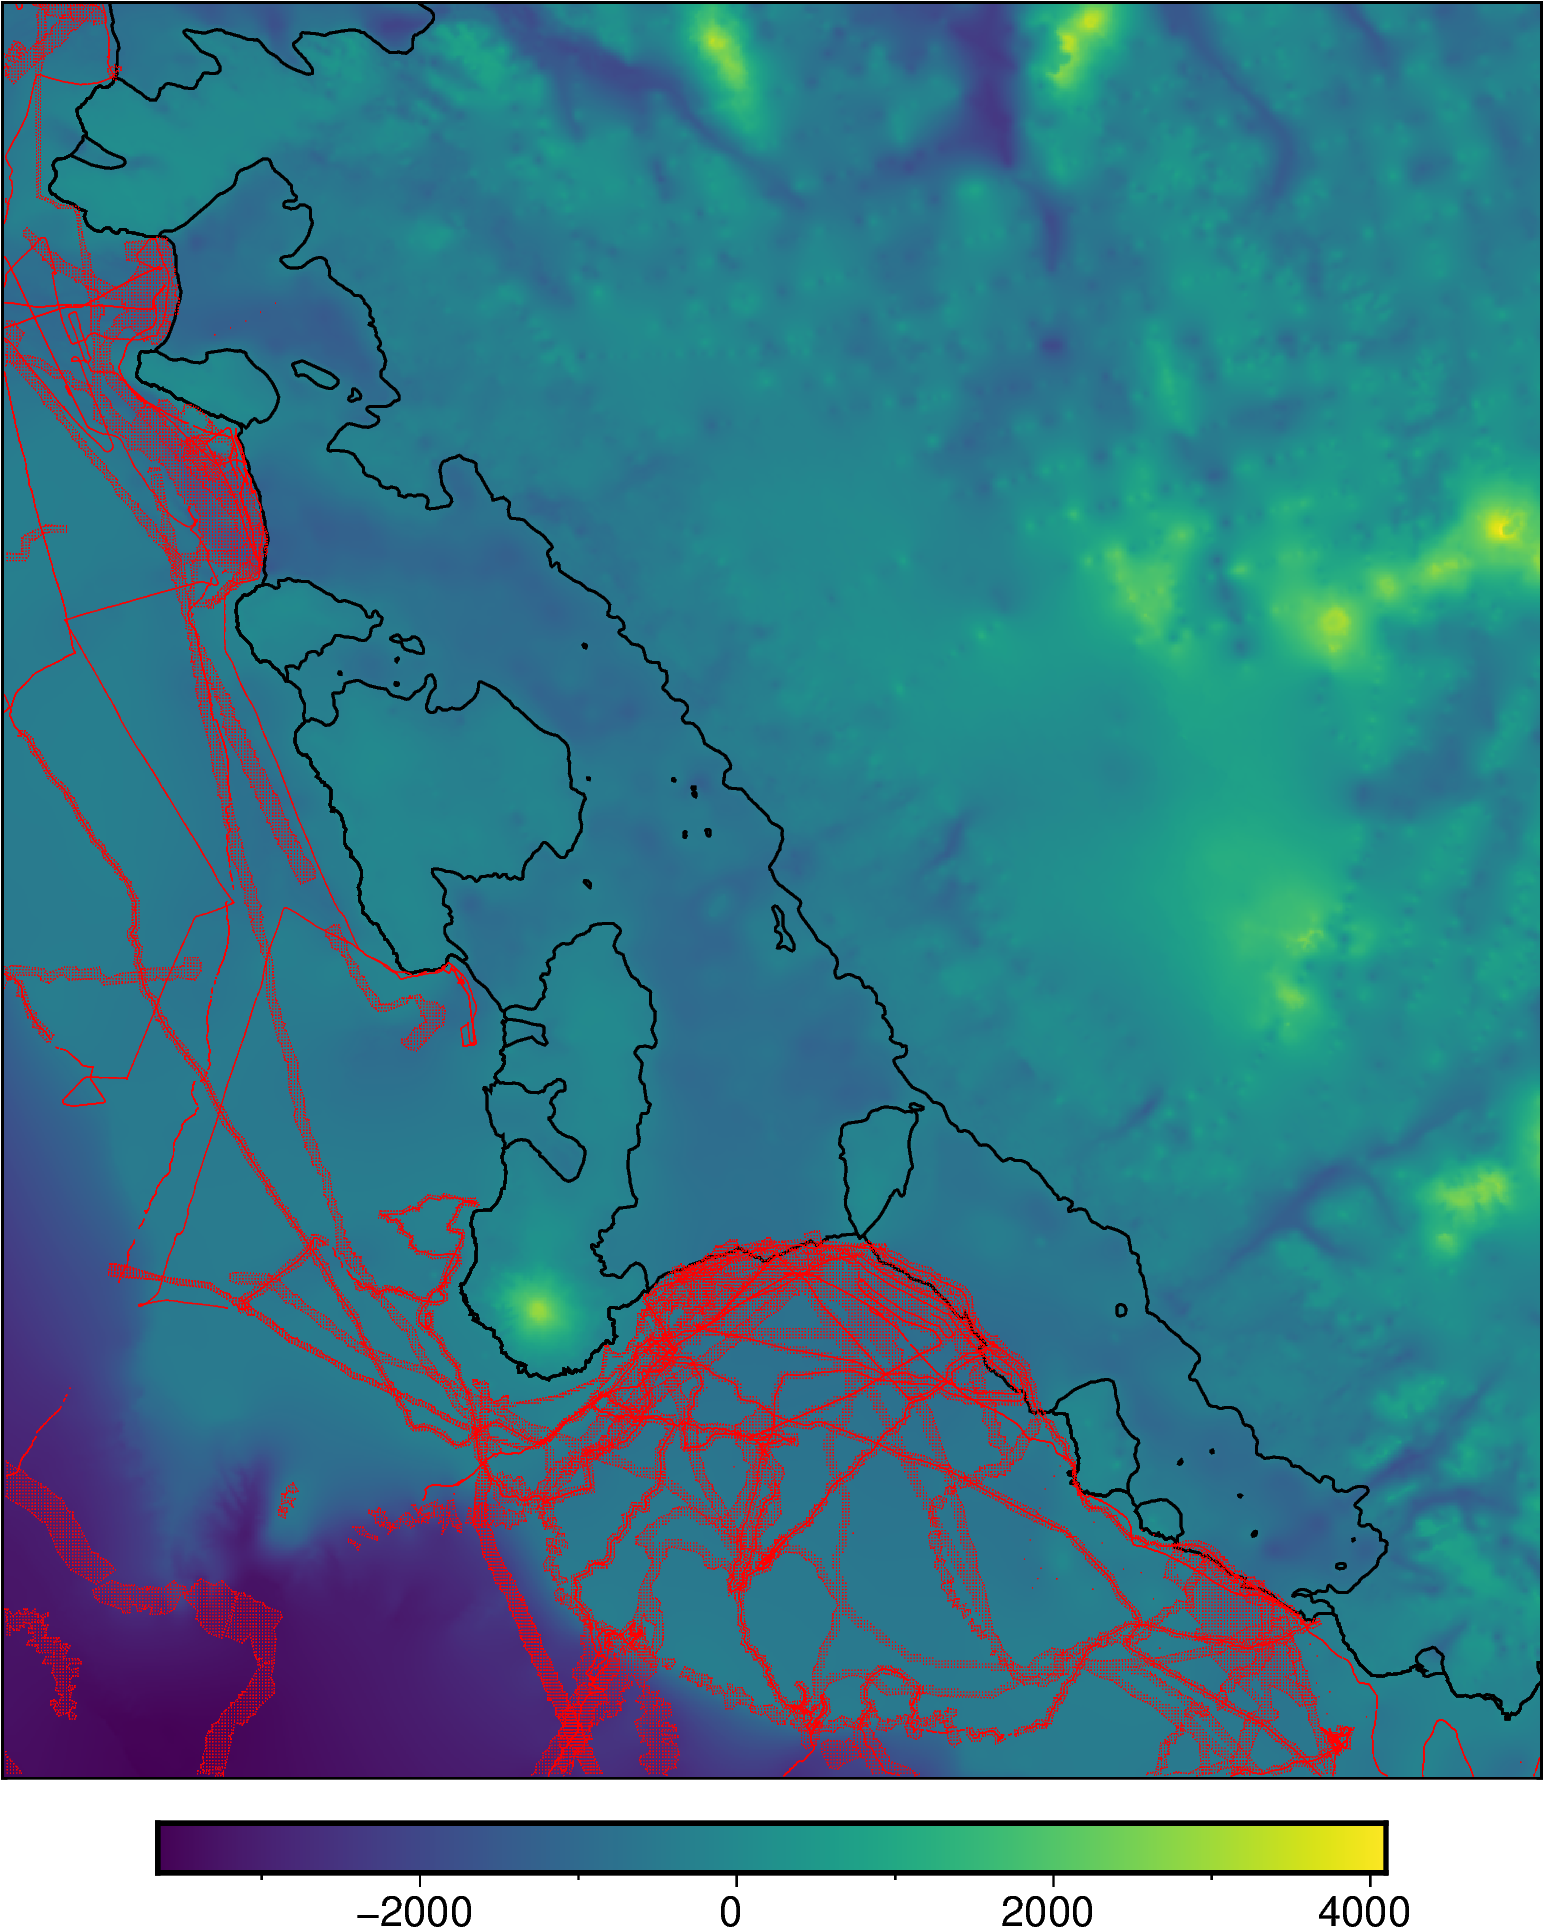

In [6]:
fig = maps.plot_grd(bed_topography, coast=True)
fig.add_points(offshore_points, style="p.2p", fill="red")
fig.show()

# Combine onshore and offshore points

In [7]:
constraint_points =  pd.concat(
    [offshore_points, onshore_points],
    ignore_index=True,
    sort=False,
)

# drop unnecessary columns
constraint_points = constraint_points.drop(columns=["dataset_name", "dataid", "source"])
constraint_points

easting      northing
0      -1.419333e+06 -1.188782e+06
1      -1.448801e+06 -1.233985e+06
2      -1.448857e+06 -1.233818e+06
3      -1.448893e+06 -1.233642e+06
4      -1.448882e+06 -1.233529e+06
...              ...           ...
154118 -1.139500e+06 -1.214500e+06
154119 -1.140000e+06 -1.215000e+06
154120 -1.139500e+06 -1.215000e+06
154121 -1.140500e+06 -1.215500e+06
154122 -1.140000e+06 -1.215500e+06

[154123 rows x 2 columns]

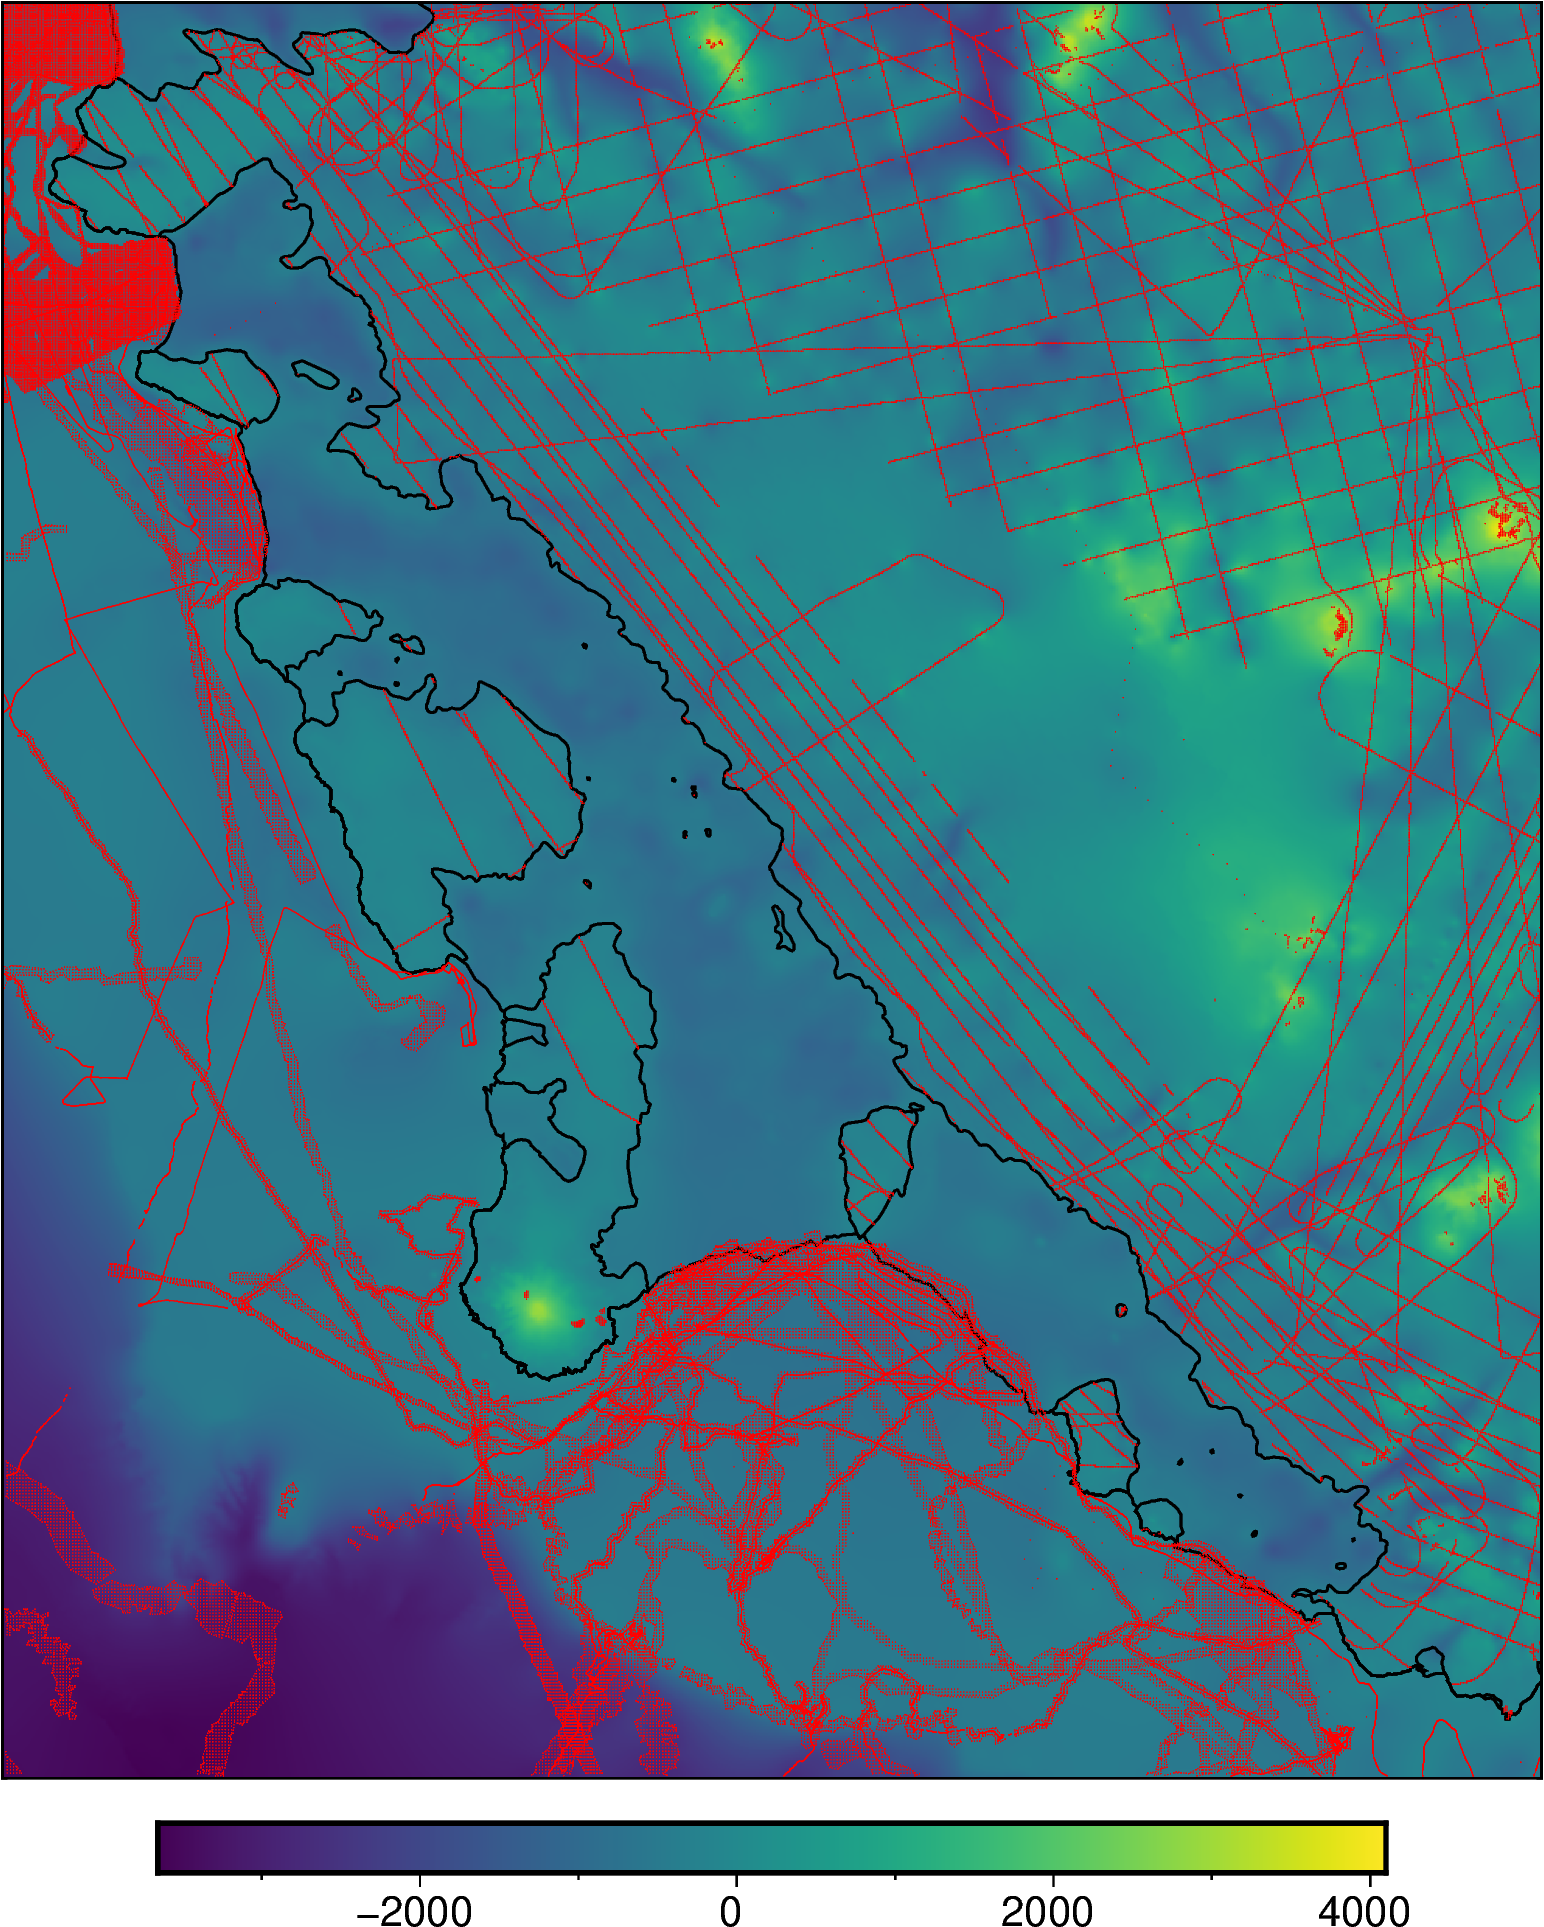

In [8]:
fig = maps.plot_grd(bed_topography, coast=True)
fig.add_points(constraint_points, style="p.2p", fill="red")
fig.show()

# Block reduce

In [9]:

# block median with 1km blocks
reducer = vd.BlockReduce(reduction=np.median, spacing=1e3)
coordinates, data = reducer.filter(
    (constraint_points.easting, constraint_points.northing),
    np.ones_like(constraint_points.easting)
)

constraint_points = pd.DataFrame({"easting": coordinates[0], "northing": coordinates[1]})
constraint_points


easting   northing
0     -1.624000e+06 -1234000.0
1     -1.622000e+06 -1234000.0
2     -1.621001e+06 -1234000.0
3     -1.620001e+06 -1234000.0
4     -1.619001e+06 -1234000.0
...             ...        ...
55577 -1.154000e+06  -664000.0
55578 -1.152750e+06  -664500.0
55579 -1.147000e+06  -664000.0
55580 -1.136500e+06  -664500.0
55581 -1.131000e+06  -664000.0

[55582 rows x 2 columns]

In [10]:
''
# block median with 1km blocks
reducer = vd.BlockReduce(reduction=np.median, spacing=1e3)
coordinates, data = reducer.filter(
    (constraint_points.easting, constraint_points.northing),
    np.ones_like(constraint_points.easting)
)

constraint_points = pd.DataFrame({"easting": coordinates[0], "northing": coordinates[1]})
constraint_points
''

''

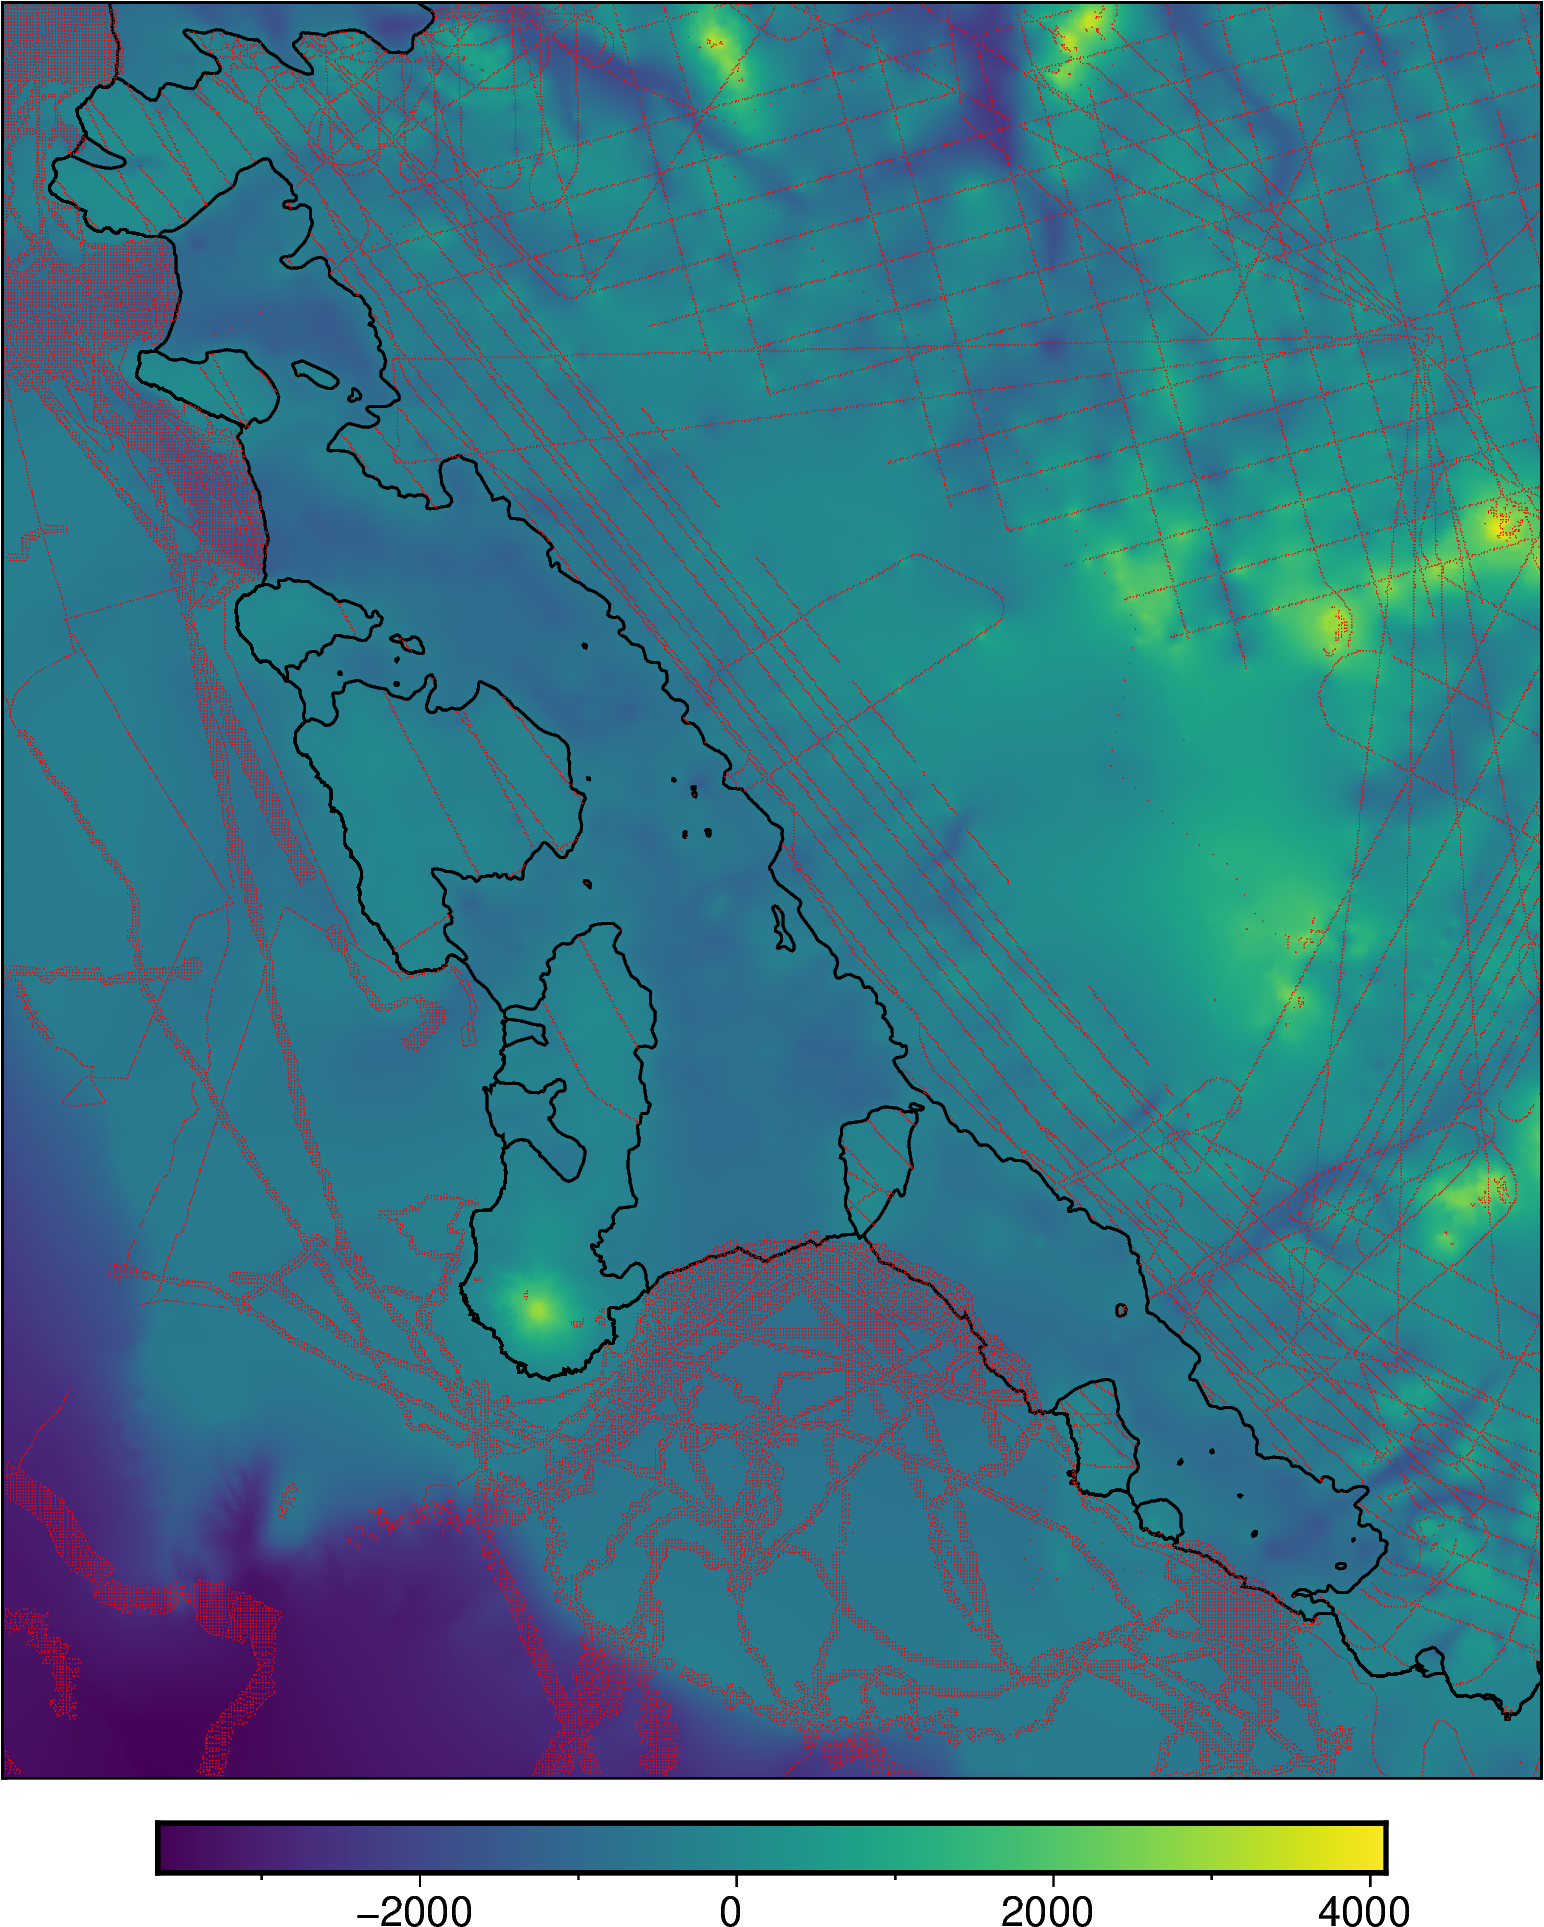

''

In [11]:
''
fig = maps.plot_grd(bed_topography, coast=True)
fig.add_points(constraint_points, style="p.2p", fill="red")
fig.show()
''

# Sample bed topography grid at these points

In [12]:
# sample bedrock topography at points
constraint_points = profiles.sample_grids(constraint_points, bed_topography, sampled_name="bed_elevation")

# drop points without bed elevation
constraint_points = constraint_points.dropna(subset=["bed_elevation"])
constraint_points

grdtrack [WARNING]: Some input points were outside the grid domain(s).


easting      northing  bed_elevation
8     -1.559078e+06 -1.233548e+06   -3538.024543
9     -1.558187e+06 -1.233347e+06   -3531.229456
10    -1.557547e+06 -1.233500e+06   -3520.570221
11    -1.556466e+06 -1.233429e+06   -3513.796082
12    -1.555333e+06 -1.233868e+06   -3512.433386
...             ...           ...            ...
55299 -1.154000e+06 -6.640000e+05    -957.328003
55300 -1.152750e+06 -6.645000e+05    -961.495514
55301 -1.147000e+06 -6.640000e+05    -362.992767
55302 -1.136500e+06 -6.645000e+05     -96.594223
55303 -1.131000e+06 -6.640000e+05    -701.685425

[55226 rows x 3 columns]

# Save to CSV

In [13]:
constraint_points.to_csv("constraint_points.csv", index=False)